# Определение выгодного тарифа для телеком-оператора 

## Описание проекта
<a class=anchor id=one></a>

### Постановка задачи
<a class=anchor id=one-one></a>

Абонентам сотового Оператора предлагают два тарифных плана:
- `«Смарт»`
- `«Ультра»` 

Для корректировки маркетинговой активности Оператор хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке. В распоряжении есть данные абонентов: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за год.

**Задача:** проанализировать поведение абонентов и сделать вывод — какой тариф лучше.

### Описание тарифов
<a class=anchor id=one-two></a>

**`Тариф «Смарт»`**

- Ежемесячная плата: 550 рублей
- Включено: 500 минут разговора, 50 сообщений, 15 Гб трафика

Стоимость услуг сверх тарифного пакета: 
1. Минута разговора: 3 рубля; 
2. Cообщение: 3 рубля; 
3. 1 Гб трафика: 200 рублей.


**`Тариф «Ультра»`**

- Ежемесячная плата: 1950 рублей
- Включено: 3000 минут разговора, 1000 сообщений, 30 Гб трафика

Стоимость услуг сверх тарифного пакета:

1. Минута разговора: 1 рубль;
2. Сообщение: 1 рубль;
3. 1 Гб трафика: 150 рублей.

**Примечание:**

Оператор округляет секунды до минут, а Мб — до Гб.<br>
Каждый звонок округляется отдельно: даже если он длился всего 1 сек., будет засчитан как 1 мин.<br>
Для трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 Мб в месяце, с него возьмут плату за 2 Гб.

## Чтение данных
<a class=anchor id=two></a>

Импорт необходимых библиотек:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import random
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Чтение данных

In [2]:
calls = pd.read_csv('datasets/calls.csv')
internet = pd.read_csv('datasets/internet.csv')
messages = pd.read_csv('datasets/messages.csv')
tariffs = pd.read_csv('datasets/tariffs.csv')
users = pd.read_csv('datasets/users.csv')

Устанавливаем константы,  параметры отображения данных `float`

In [3]:
DATE_FORMAT_TEMPLATE = '%Y-%m-%d'
RND_ST = 42
pd.set_option('display.float_format', '{:.2f}'.format)

### Датафрейм `calls`
<a class=anchor id=two-one></a>

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
calls.sample(7)

,id,call_date,duration,user_id
56956,1144_327,2018-06-24,14.91,1144
189839,1467_106,2018-12-09,10.97,1467
49830,1124_49,2018-12-28,1.50,1124
80604,1200_507,2018-09-25,2.84,1200
26573,1065_660,2018-10-25,10.83,1065
118108,1303_376,2018-11-18,0.00,1303
147860,1375_691,2018-08-01,8.92,1375


In [6]:
calls.describe()

,duration,user_id
count,202607.00,202607.00
mean,6.76,1253.94
std,5.84,144.72
min,0.00,1000.00
25%,1.30,1126.00
50%,6.00,1260.00
75%,10.70,1379.00
max,38.00,1499.00


In [7]:
calls['user_id'].nunique()

492

<a id=calls_info> </a>
**Вывод:** датафрейм `calls` содержит 202 607 наблюдений, состоящих из 4 столбцов, пропусков в данных нет. Наблюдения есть для 492 пользователей, диапазон значений в столбце `duration` от 0 до 38 мин., медиана и среднее (6.00 и 6.76) очень близкие, выборка немного скошена "вправо". Малая разница показывает, что больших выбросов нет. Типы данных: float64(1), int64(1), object(2). Названия столбцов соответствуют принятым правилам наименований. Требуется провести:
- столбец `call_date` из `object` в формат `datetime`
- столбец `duration` округлить в бОльшую сторону до целых значений, привести к типу `int`

### Датафрейм `internet`
<a class=anchor id=two-two></a>

In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [9]:
internet.sample(10)

,Unnamed: 0,id,mb_used,session_date,user_id
141005,141005,1473_19,243.20,2018-08-10,1473
45140,45140,1155_327,677.91,2018-01-05,1155
10018,10018,1034_8,57.81,2018-10-23,1034
15540,15540,1054_520,358.97,2018-05-23,1054
137398,137398,1460_333,538.18,2018-04-25,1460
54729,54729,1184_8,652.02,2018-12-19,1184
124996,124996,1421_181,570.94,2018-03-23,1421
103472,103472,1348_130,612.94,2018-10-07,1348
105020,105020,1356_19,503.56,2018-12-04,1356
93721,93721,1317_28,113.44,2018-07-14,1317


In [10]:
internet = internet.drop('Unnamed: 0', axis=1)

In [11]:
internet.describe()

,mb_used,user_id
count,149396.00,149396.00
mean,370.19,1252.10
std,278.30,144.05
min,0.00,1000.00
25%,138.19,1130.00
50%,348.01,1251.00
75%,559.55,1380.00
max,1724.83,1499.00


In [12]:
internet['user_id'].nunique()

497

<a id=internet_info> </a>
**Вывод:** Датафрейм содержит 149 396 наблюдений, пропусков в данных нет, названия столбцов соответствуют принятым правилам наименований. Столбец `Unnamed: 0` является дубликатом индекса. Его удалили, после удаления датафрейм содержит 4 столбца `id`, `mb_used`, `session_date`,	`user_id`. Данные есть для 497 пользователей. Значения в столбце `mb_used` в диапазоне `[0, 1724.83]`. Медиана и среднее (348.01 и 370.19) достаточно близки, данные в столбце `mb_used` немного скошены "вправо". Типы данных в столбцах: float64(1), int64(1), object(2). Столбец `session_date` нужно привести к формату `datetime`, значения в столбце `user_id` привести к оптимальному типу `int`.

### Датафрейм `messages`
<a class=anchor id=two-three></a>

In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [14]:
messages.sample(7)

,id,message_date,user_id
69698,1298_146,2018-09-09,1298
100247,1411_83,2018-09-26,1411
15739,1067_173,2018-12-05,1067
30973,1135_7,2018-10-11,1135
53641,1238_54,2018-09-05,1238
67408,1285_596,2018-05-31,1285
118245,1481_16,2018-12-08,1481


In [15]:
messages['user_id'].nunique()

426

<a id=messages_info> </a>
**Вывод:** Датафрейм содержит 123 036 наблюдений, пропусков в данных нет, названия столбцов соответствуют принятым правилам наименований. Данные есть для 426 пользователей. Типы данных в столбцах: int64(1), object(2). Столбец `message_date` нужно привести к формату `datetime`

### Датафрейм `tariffs`
<a class=anchor id=two-four></a>

In [16]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [17]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Вывод:** Датафрейм содержит 2 наблюдения, пропусков в данных нет, названия столбцов соответствуют принятым правилам наименований, целые типы данных можно оптимизировать.

### Датафрейм `users`
<a class=anchor id=two-five></a>

In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [19]:
users.sample(9, random_state=RND_ST)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
361,1361,38,NaN,Екатеринбург,Рената,Кошелева,2018-09-09,ultra
73,1073,63,NaN,Владикавказ,Гордей,Павловский,2018-10-04,smart
374,1374,67,NaN,Махачкала,Леонид,Аркадьев,2018-04-01,smart
155,1155,71,NaN,Ставрополь,Александр,Чернов,2018-01-02,smart
104,1104,60,NaN,Нижний Тагил,Габриэль,Поляков,2018-02-21,ultra
394,1394,47,NaN,Орёл,Ксения,Жукова,2018-01-12,smart
377,1377,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra
124,1124,54,NaN,Махачкала,Альбин,Андрианов,2018-09-24,ultra
68,1068,34,NaN,Москва,Ким,Демьянов,2018-07-16,smart


In [20]:
users.describe()

,user_id,age
count,500.00,500.00
mean,1249.50,46.59
std,144.48,16.67
min,1000.00,18.00
25%,1124.75,32.00
50%,1249.50,46.00
75%,1374.25,62.00
max,1499.00,75.00


In [21]:
users['user_id'].nunique()

500

**Вывод:** Датафрейм содержит 500 записей в 8 столбцах, пропуски данных (462) в столбце `churn_date`, названия столбцов соответствуют принятым правилам наименований, значения в столбцах `city`, `first_name`, `last_name` нужно привести к нижнему регистру. Типы данных в столбцах: int64(2), object(6). Значения в столбце `age` в диапазоне `[18, 75]`, неадекватных значений нет. Медиана и среднее (46 и 46.59) практически равны, распределение данных близко к нормальному.  Столбцы `churn_date` и `reg_date` нужно привести к формату `datetime`. Целочисленные данные в столбцах `user_id` и `age` необходимо привести к оптимальному типу.

## Преобразование типов данных
<a class=anchor id=three></a>

### Датафрейм `calls`
<a class=anchor id=three-one></a>

По условиям тарификации все звонки округляются до минут в большую сторону. Создадим столбец `duration_int` с целочисленными значениями длительности, округленными в бОльшую сторону, тип данных `int`.

In [22]:
calls['duration_int'] = calls['duration'].apply(mt.ceil).astype('int')

Дату в столбце `call_date` приведем к типу `datetime`, добавим столбец с значением месяца.

In [23]:
calls['call_date'] = pd.to_datetime( calls['call_date'], format=DATE_FORMAT_TEMPLATE )
calls = calls.assign(month = lambda x: pd.DatetimeIndex(x['call_date']).month)

Приведем целочисленные данные к оптимальным типам. Для этой операции создадим функцию `tune_int_types`, которая будет оптимизировать целочисленные типы в переданном датафрейме.

In [24]:
def tune_int_types(df):
    int_types = df.select_dtypes(include=['integer']).apply(pd.to_numeric, downcast='integer')
    for item in int_types.dtypes.index:
        df.loc[:, item] = df[item].astype(int_types.dtypes[item])

In [25]:
tune_int_types(calls)

Контроль операций:

In [26]:
calls.sample(5)

,id,call_date,duration,user_id,duration_int,month
129877,1332_188,2018-11-19,21.81,1332,22,11
66134,1168_1285,2018-08-10,10.26,1168,11,8
135782,1346_332,2018-10-28,10.84,1346,11,10
24172,1061_252,2018-09-13,11.41,1061,12,9
29058,1072_384,2018-06-10,0.00,1072,0,6


In [27]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            202607 non-null  object        
 1   call_date     202607 non-null  datetime64[ns]
 2   duration      202607 non-null  float64       
 3   user_id       202607 non-null  int16         
 4   duration_int  202607 non-null  int8          
 5   month         202607 non-null  int8          
dtypes: datetime64[ns](1), float64(1), int16(1), int8(2), object(1)
memory usage: 5.4+ MB


**Вывод:** округлили длительность звонков до целых значений вверх, сохранили результат в столбце `duration_int`, преобразовали дату в формат `datetime`, добавли столбец `month` с номером месяца звонка. Целочисленные данные преобразовали к оптимальным типам. Размер датафрейма `calls` уменьшился (c 6.2+ MB до 5.4+ MB)

### Датафрейм `internet`
<a class=anchor id=three-two></a>

Дату в столбце `session_date` приведем к типу `datetime`, добавим столбец с номером месяца.

In [28]:
internet['session_date'] = pd.to_datetime( internet['session_date'], format=DATE_FORMAT_TEMPLATE )
internet = internet.assign(month = lambda x: pd.DatetimeIndex(x['session_date']).month)

Приведем данные в столбцах `user_id` и `session_month` к оптимальному целому типу.

In [29]:
tune_int_types(internet)

In [30]:
internet.sample(5)

,id,mb_used,session_date,user_id,month
9718,1033_98,232.13,2018-12-24,1033,12
77426,1262_78,813.70,2018-04-09,1262,4
107052,1363_98,321.66,2018-12-29,1363,12
68574,1233_33,567.74,2018-05-24,1233,5
66668,1227_265,183.54,2018-01-24,1227,1


In [31]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int16         
 4   month         149396 non-null  int8          
dtypes: datetime64[ns](1), float64(1), int16(1), int8(1), object(1)
memory usage: 3.8+ MB


**Вывод:** преобразовали дату в формат `datetime`, добавли столбец `month` с номером месяца. Целочисленные данные преобразовали к оптимальным типам. Размер датафрейма `internet` уменьшился (c 5.7+ MB до 3.8+ MB)

### Датафрейм `messages`
<a class=anchor id=three-three></a>

Дату в столбце `message_date` приведем к типу `datetime`, добавим столбец с номером месяца.

In [32]:
messages['message_date'] = pd.to_datetime( messages['message_date'], format=DATE_FORMAT_TEMPLATE )
messages = messages.assign(month = lambda x: pd.DatetimeIndex(x['message_date']).month)

Оптимизируем тип целочисленных данных:

In [33]:
tune_int_types(messages)

In [34]:
messages.sample(5)

,id,message_date,user_id,month
72520,1307_164,2018-09-11,1307,9
71566,1302_394,2018-11-03,1302,11
49419,1218_12,2018-08-15,1218,8
98864,1404_4,2018-06-29,1404,6
64390,1277_1067,2018-09-27,1277,9


In [35]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int16         
 3   month         123036 non-null  int8          
dtypes: datetime64[ns](1), int16(1), int8(1), object(1)
memory usage: 2.2+ MB


**Вывод:** преобразовали дату в формат `datetime`, добавли столбец `month` с номером месяца. Целочисленные данные преобразовали к оптимальным типам. Размер датафрейма `messages` уменьшился (c 2.8+ MB до 2.2+ MB)

### Датафрейм `tariffs`
<a class=anchor id=three-four></a>

Оптимизируем типы целочисленных данных:

In [36]:
tune_int_types(tariffs)

Переименуем столбец `tariff_name` в `tariff` (для единообразия с названием в датасете `users`)

In [37]:
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)

In [38]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [39]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int16 
 1   mb_per_month_included  2 non-null      int16 
 2   minutes_included       2 non-null      int16 
 3   rub_monthly_fee        2 non-null      int16 
 4   rub_per_gb             2 non-null      int16 
 5   rub_per_message        2 non-null      int8  
 6   rub_per_minute         2 non-null      int8  
 7   tariff                 2 non-null      object
dtypes: int16(5), int8(2), object(1)
memory usage: 168.0+ bytes


**Вывод:** Целочисленные данные преобразовали к оптимальным типам. Размер датафрейма `tariffs` уменьшился (c 256.0+ bytes до 168.0+ bytes)

### Датафрейм `users`
<a class=anchor id=three-five></a>

Даты в столбцах `churn_date` и `reg_date` приведем к типу `datetime`:

In [40]:
for item in ['churn_date', 'reg_date']:
    users[item] = pd.to_datetime( users[item], format=DATE_FORMAT_TEMPLATE )

Приводим все строковые данные к нижнему регистру:

In [41]:
for item in users.columns:
    try:
        users[item] = users[item].str.lower().str.strip()
    except:
        pass

Оптимизируем типы целочисленных данных:

In [42]:
tune_int_types(users)

Контроль операций:

In [43]:
users.sample(7, random_state=RND_ST)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
361,1361,38,NaT,екатеринбург,рената,кошелева,2018-09-09,ultra
73,1073,63,NaT,владикавказ,гордей,павловский,2018-10-04,smart
374,1374,67,NaT,махачкала,леонид,аркадьев,2018-04-01,smart
155,1155,71,NaT,ставрополь,александр,чернов,2018-01-02,smart
104,1104,60,NaT,нижний тагил,габриэль,поляков,2018-02-21,ultra
394,1394,47,NaT,орёл,ксения,жукова,2018-01-12,smart
377,1377,59,NaT,брянск,альфред,семин,2018-02-25,ultra


Проверим на дубликаты

In [44]:
users.duplicated().sum()

0

In [45]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int16         
 1   age         500 non-null    int8          
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int16(1), int8(1), object(4)
memory usage: 25.0+ KB


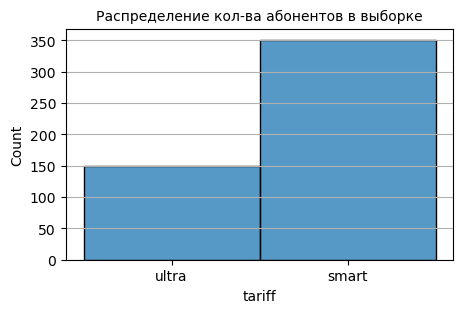

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.histplot(users, x='tariff')
ax.grid(axis='y')
ax.set_title('Распределение кол-ва абонентов в выборке', size=10)
plt.show()

**Вывод:** Данные в столбцах `churn_date` и `reg_date` приведены к формату `datetime`. Значения в столбцах `city`, `first_name`, `last_name` приведены к нижнему регистру. Целочисленные данные в столбцах `user_id` и `age` приведены к оптимальному типу. Размер датафрейма уменьшился с 31.4+ KB до 25.0+ KB. В данных присутствуют 150 абонентов `ultra` и 350 абонентов `smart`

## Расчеты показателей абонента
<a class=anchor id=four></a>

### Кол-во звонков и израсходованных минут разговора по месяцам
<a class=anchor id=four-one></a>

Создадим таблицу `calls_per_months` для каждого пользователя, для которого есть данные по звонкам:
- id
- номер месяца
- кол-во звонков за месяц
- кол-во минут разговора за месяц (целое значение минут берем из столбца `duration_int`)
- название тарифа
- кол-во минут, включенных в тариф
- кол-во минут разговора за месяц сверх лимита тарифа (или 0, если превышения нет)

In [47]:
def smart_diff(Series_1, Series_2):
    '''функция возвращает Series, которая равна разности между Series_1 и Series_2
       в итоговой Series отрицательные значения заменены на 0'''
    
    return (Series_1 - Series_2).apply(lambda v: v if v>0 else 0)

In [48]:
calls_per_months = (
    calls
    .groupby(['user_id', 'month'])
    .agg(
        calls_qty = ('id',  'count'),
        minutes_used = ('duration_int', 'sum')
    )
    .reset_index()
    .merge(
        users[['user_id', 'tariff']],
        on='user_id',
        how='left'
    )
    .merge(
        tariffs[['tariff', 'minutes_included']],
        on='tariff'
    )
    .assign(
        minutes_over_limit = lambda x: smart_diff(
            x['minutes_used'], x['minutes_included']
        )
    )    
)

Переведем `float` в `int`, оптимизируем типы целочисленных данных:

In [49]:
float_col = calls_per_months.select_dtypes(include=['float']).columns
calls_per_months[float_col] = calls_per_months[float_col].astype('int')
tune_int_types(calls_per_months)

Выведем 10 случайных строк таблицы `calls_per_months`:

In [50]:
calls_per_months.sample(10, random_state=RND_ST)

,user_id,month,calls_qty,minutes_used,tariff,minutes_included,minutes_over_limit
2270,1288,10,65,505,smart,500,5
442,1271,8,52,389,ultra,3000,0
2885,1433,4,66,406,smart,500,0
1655,1155,6,46,289,smart,500,0
1001,1009,11,39,290,smart,500,0
2563,1362,12,54,315,smart,500,0
1771,1176,8,56,432,smart,500,0
2339,1302,11,34,252,smart,500,0
214,1126,1,35,272,ultra,3000,0
1566,1135,2,66,439,smart,500,0


In [51]:
calls_per_months.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             3174 non-null   int16 
 1   month               3174 non-null   int8  
 2   calls_qty           3174 non-null   int16 
 3   minutes_used        3174 non-null   int16 
 4   tariff              3174 non-null   object
 5   minutes_included    3174 non-null   int16 
 6   minutes_over_limit  3174 non-null   int16 
dtypes: int16(5), int8(1), object(1)
memory usage: 83.7+ KB


**Вывод:** в таблице `calls_per_months` собрана информация о кол-ве звонков, сумме минут разговора и превышении лимита по минутам для каждого пользователя по месяцам. Типы данных оптимизированы.

### Количество отправленных сообщений по месяцам
<a class=anchor id=four-two></a>

Создадим таблицу `messages_per_months` для каждого пользователя, для которого есть данные по сообщениям:
- id
- номер месяца
- кол-во сообщений за месяц
- название тарифа
- кол-во сообщений, включенных в тариф
- кол-во сообщений за месяц сверх лимита тарифа (или 0, если превышения нет)

In [52]:
messages_per_months = (
    messages
    .groupby(['user_id', 'month'])
    .agg(messages_qty = ('id', 'count') )
    .reset_index()
    .merge(
        users[['user_id', 'tariff']],
        on='user_id',
        how='left'
    )
    .merge(
        tariffs[['tariff', 'messages_included']],
        on='tariff'
    )
    .assign(
        messages_over_limit = lambda x: smart_diff(
            x['messages_qty'], x['messages_included']
        )
    )    
)

In [53]:
tune_int_types(messages_per_months)

In [54]:
messages_per_months.sample(10, random_state=RND_ST)

,user_id,month,messages_qty,tariff,messages_included,messages_over_limit
2071,1327,7,52,smart,50,2
443,1330,11,79,ultra,1000,0
1397,1154,7,13,smart,50,0
2566,1468,2,5,smart,50,0
1017,1055,6,34,smart,50,0
1174,1088,11,37,smart,50,0
565,1380,8,26,ultra,1000,0
912,1031,11,25,smart,50,0
2716,1499,12,66,smart,50,16
610,1391,11,3,ultra,1000,0


In [55]:
messages_per_months.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2717 entries, 0 to 2716
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              2717 non-null   int16 
 1   month                2717 non-null   int8  
 2   messages_qty         2717 non-null   int16 
 3   tariff               2717 non-null   object
 4   messages_included    2717 non-null   int16 
 5   messages_over_limit  2717 non-null   int8  
dtypes: int16(3), int8(2), object(1)
memory usage: 63.7+ KB


**Вывод:** в таблице `messages_per_months` собрана информация о кол-ве сообщений и превышении лимита по кол-ву сообщений для каждого пользователя по месяцам. Типы данных оптимизированы.

### Объем израсходованного интернет-трафика по месяцам
<a class=anchor id=four-three></a>

Создадим таблицу `internet_per_months`, где для каждого пользователя, для которого есть данные по трафику ([Тут](#internet_info) есть данные по кол-ву пользователей, для которых есть информация по трафику), будет:
- id
- номер месяца
- фактический трафик в Мб
- расчетный трафик в Гб по правилам Оператора
- название тарифа
- кол-во Гб трафика, включенных в тариф
- кол-во Гб сверх лимита тарифа (или 0, если превышения нет)

In [56]:
def calc_month_internet_gb(ser):
    '''возвращает целое число Гб, рассчитанное по правилам Оператора'''
    
    return ser.apply( lambda v: mt.ceil(v/1024) )

In [57]:
internet_per_months = (
    internet
    .groupby(['user_id', 'month'])
    .agg(mb_per_month_fact = ('mb_used', 'sum') )
    .reset_index()
    .assign(
        gb_per_month_calc = lambda x: calc_month_internet_gb(x['mb_per_month_fact'])
    )
    .merge(
        users[['user_id', 'tariff']],
        on='user_id',
        how='left'
    )
    .merge(
        tariffs[['tariff', 'mb_per_month_included']],
        on='tariff'
    )
    .assign(
        gb_per_month_included = lambda y: (y['mb_per_month_included']/1024).astype(
            'int'
        )
    )
    .drop('mb_per_month_included', axis=1 )
    .assign(gb_over_limit = lambda z: smart_diff(
        z['gb_per_month_calc'], z['gb_per_month_included']
    ).astype('int')
           )
)

Оптимизируем типы целочисленных данных

In [58]:
tune_int_types(internet_per_months)

Выведем 10 случайных строк

In [59]:
internet_per_months.sample(10, random_state=RND_ST)

,user_id,month,mb_per_month_fact,gb_per_month_calc,tariff,gb_per_month_included,gb_over_limit
3008,1459,12,16076.44,16,smart,15,1
102,1063,8,13866.29,14,ultra,30,0
862,1440,9,22591.44,23,ultra,30,0
867,1442,12,38999.57,39,ultra,30,9
999,1006,5,12965.41,13,smart,15,0
1423,1101,6,10435.43,11,smart,15,0
2956,1446,10,14123.88,14,smart,15,0
598,1335,10,15584.22,16,ultra,30,0
170,1096,7,13432.77,14,ultra,30,0
1720,1161,11,4617.07,5,smart,15,0


In [60]:
internet_per_months.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3203 entries, 0 to 3202
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3203 non-null   int16  
 1   month                  3203 non-null   int8   
 2   mb_per_month_fact      3203 non-null   float64
 3   gb_per_month_calc      3203 non-null   int8   
 4   tariff                 3203 non-null   object 
 5   gb_per_month_included  3203 non-null   int8   
 6   gb_over_limit          3203 non-null   int8   
dtypes: float64(1), int16(1), int8(4), object(1)
memory usage: 93.8+ KB


**Вывод:** в таблице `internet_per_months` собрана информация о фактическом трафике (Мб), о расчетном трафике в соответствии с правилами расчета Оператора (Гб) и превышении лимита трафика (Гб) для каждого пользователя по месяцам. Типы данных оптимизированы.

### Расчет помесячной выручки с каждого абонента
<a class=anchor id=four-four></a>

Объединим таблицы `calls_per_months`, `messages_per_months` и `internet_per_months` по столбцам `'user_id', 'month', 'tariff'`, добавляя стобцы с необходимыми для расчета значениями:
- `minutes_over_limit`
- `messages_over_limit`
- `gb_over_limit`

Тогда для каждого пользователя мы будем знать его тариф и помесячно объемы превышения по минутам, сообщениям и Гб трафика.


Далее можно будет вычислить ежемесячную выручку для каждого пользователя, сложив:
- абонентскую плату (используем значение `tariff`)
- размер доп. платежа за превышение лимита минут (используем значение `minutes_over_limit`)
- размер доп. платежа за превышение лимита сообщений (используем значение `messages_over_limit`)
- размер доп. платежа за превышение лимита трафика (используем значение `gb_over_limit`)

In [61]:
user_pivot = (
    calls_per_months[['user_id', 'month', 'tariff', 'minutes_over_limit']]
    .merge(
        messages_per_months[['user_id', 'month', 'tariff', 'messages_over_limit']],
        on=['user_id', 'month', 'tariff'],
        how='outer'
    )
    .merge(
        internet_per_months[['user_id', 'month', 'tariff', 'gb_over_limit']],
        on=['user_id', 'month', 'tariff'],
        how='outer'
    )
    .sort_values(by=['user_id', 'month'])
    .reset_index(drop=True)
)

In [62]:
user_pivot.head(10)

,user_id,month,tariff,minutes_over_limit,messages_over_limit,gb_over_limit
0,1000,5,ultra,0.00,0.00,0.00
1,1000,6,ultra,0.00,0.00,0.00
2,1000,7,ultra,0.00,0.00,0.00
3,1000,8,ultra,0.00,0.00,0.00
4,1000,9,ultra,0.00,0.00,0.00
5,1000,10,ultra,0.00,0.00,0.00
6,1000,11,ultra,0.00,0.00,0.00
7,1000,12,ultra,0.00,0.00,0.00
8,1001,11,smart,0.00,NaN,3.00
9,1001,12,smart,0.00,NaN,0.00


Как видно из первых 10 значений, в данных есть пропуски. Выведем кол-во пропусков в данных:

In [63]:
user_pivot.isna().sum()

user_id                  0
month                    0
tariff                   0
minutes_over_limit      40
messages_over_limit    497
gb_over_limit           11
dtype: int64

Пропуски образовались, так как объединяемые датафреймы не идентичны по набору `user_id`. Мы видели разницу в кол-ве уникальных `user_id` в датафреймах `calls`, `messages` и `internet` на этапе 2. Пропуски целесообразно заполнить нулями т.к. в процессе расчета выручки нули не исказят итоговый результат.

In [64]:
user_pivot = user_pivot.fillna(0)

Проверим на полноту представления абонентов:

In [65]:
user_pivot['user_id'].nunique()

498

Датафрейм `user_pivot` содержит данные для 498 уникальных абонентов, а в датафрейме `users` их 500. Посмотрим, какие абоненты отсутствуют:

In [66]:
bad_users = set(users['user_id'].unique()) - set(user_pivot['user_id'].unique())

Проверим, какие есть данные для абонентов из `bad_users` в датафреймах `calls`, `messages`, `internet` и `users`:

In [67]:
for item in bad_users:
    for df in [calls, messages, internet, users]:
        display( df[df['user_id'] == item] )

,id,call_date,duration,user_id,duration_int,month


,id,message_date,user_id,month


,id,mb_used,session_date,user_id,month


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,волжский,ксения,агаева,2018-12-15,ultra


,id,call_date,duration,user_id,duration_int,month


,id,message_date,user_id,month


,id,mb_used,session_date,user_id,month


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
371,1371,50,2018-12-30,омск,ириней,трофимов,2018-12-25,smart


Из результатов видно, что абоненты пользовались услугами Оператора несколько дней и статистики по ним просто нет. Можно удалить эти строки из датафрейма `users`.

In [68]:
users = users.drop(
    index=users.query('user_id in @bad_users').index
).reset_index(drop=True)

In [69]:
users.shape

(498, 8)

Добавим в таблицу `user_pivot` расчеты, сохранив результат в таблицу `user_pivot_calc`:

In [70]:
user_pivot_calc = (
    user_pivot.merge(
        tariffs[
            ['tariff',
             'rub_per_minute',
             'rub_per_message',
             'rub_per_gb',
             'rub_monthly_fee'
            ]
        ],
        on='tariff',
        how='left'
    )
    .assign(rub_minutes_fee = lambda x: x['minutes_over_limit'] * x['rub_per_minute'])
    .assign(rub_messages_fee =  lambda y: y['messages_over_limit'] * y['rub_per_message'])
    .assign(rub_gb_fee =  lambda z: z['gb_over_limit'] * z['rub_per_gb'])
    .assign(
        rub_total =  lambda t: t['rub_monthly_fee']
        + t['rub_minutes_fee']
        + t['rub_messages_fee']
        + t['rub_gb_fee']
    )
)

Оптимизируем типы данных:

In [71]:
float_col = user_pivot_calc.select_dtypes(include=['float']).columns
user_pivot_calc[float_col] = user_pivot_calc[float_col].astype('int')
tune_int_types(user_pivot_calc)

Выведем 10 случайных строк (для удобства не показываем столбцы с данными стоимости за 1 мин/сообщ./Гб):

In [72]:
columns_to_show = ['user_id',
                   'month', 
                   'tariff',
                   'minutes_over_limit',
                   'messages_over_limit',
                   'gb_over_limit',
                   'rub_monthly_fee',
                   'rub_minutes_fee',
                   'rub_messages_fee',
                   'rub_gb_fee',
                   'rub_total'
                  ]
user_pivot_calc[columns_to_show].sample(10, random_state=RND_ST)

,user_id,month,tariff,minutes_over_limit,messages_over_limit,gb_over_limit,rub_monthly_fee,rub_minutes_fee,rub_messages_fee,rub_gb_fee,rub_total
506,1080,12,ultra,0,0,0,1950,0,0,0,1950
2513,1393,7,smart,60,6,2,550,180,18,400,1148
354,1056,5,smart,0,0,3,550,0,0,600,1150
1080,1171,8,smart,140,22,0,550,420,66,0,1036
2389,1377,4,ultra,0,0,0,1950,0,0,0,1950
1642,1260,10,smart,373,0,0,550,1119,0,0,1669
2706,1422,12,smart,0,0,0,550,0,0,0,550
2776,1431,3,smart,0,0,0,550,0,0,0,550
2362,1374,8,smart,64,27,1,550,192,81,200,1023
1741,1275,7,smart,23,0,1,550,69,0,200,819


In [73]:
user_pivot_calc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              3214 non-null   int16 
 1   month                3214 non-null   int8  
 2   tariff               3214 non-null   object
 3   minutes_over_limit   3214 non-null   int16 
 4   messages_over_limit  3214 non-null   int8  
 5   gb_over_limit        3214 non-null   int8  
 6   rub_per_minute       3214 non-null   int8  
 7   rub_per_message      3214 non-null   int8  
 8   rub_per_gb           3214 non-null   int16 
 9   rub_monthly_fee      3214 non-null   int16 
 10  rub_minutes_fee      3214 non-null   int16 
 11  rub_messages_fee     3214 non-null   int16 
 12  rub_gb_fee           3214 non-null   int16 
 13  rub_total            3214 non-null   int16 
dtypes: int16(8), int8(5), object(1)
memory usage: 116.1+ KB


**Вывод:** в таблице `user_pivot_calc` сохранены данные по ежемесячной выручке для каждого абонента. Всего присутствуют данные для 498 абонентов.

## Анализ данных
<a class=anchor id=five></a>

Создадим функцию `make_stat_df` для расчета в зависимости от тарифа:
- выборочного среднего
- дисперсии совокупности
- стандартного отклонения

В качестве аргументов передаем датафрейм (звоки, сообщения, трафик) и название целевого столбца в соотв. датафрейме

In [74]:
def make_stat_df(df, aim_col):
    trf_value = ['ultra', 'smart']
    df_1 = df[df['tariff'] == trf_value[0]][aim_col].copy()
    df_2 = df[df['tariff'] == trf_value[1]][aim_col].copy()
    
    stat_tmplt = pd.DataFrame(
        data={
            'выборочное среднее' : (df_1.mean(), df_2.mean()),
            'дисперсия': (np.var(df_1, ddof=1), np.var(df_2, ddof=1)),
            'стандартное отклонение' : (
                mt.sqrt(np.var(df_1, ddof=1)),
                mt.sqrt(np.var(df_2, ddof=1))
            )
        },
        index=trf_value
    )
    
    return stat_tmplt.T

Создадим функцию `draw_dstr` для построения гистограммы распределения и диаграммы разброса в зависимости от тарифа.

В качестве аргументов передаем датафрейм (звоки, сообщения, трафик), название целевого столбца, заголовок для графиков.

In [75]:
def draw_dstr(df, aim_col, title):
    sns.set_style('darkgrid')

    df_dstr = sns.displot(
        x=aim_col,
        col='tariff',
        kde=True,
        data=df,
        height=6,
        aspect=1.18);

    sns.catplot(
        x='tariff',
        y=aim_col,
        data=df,
        alpha=.25,
        order=['smart', 'ultra'],
        palette='dark',
        height=6,
        aspect=1.3)
    
    
    df_dstr.fig.subplots_adjust(top=.85)
    df_dstr.fig.suptitle(title, size=17);

### Распределение минут разговора в зависимости от тарифа
<a class=anchor id=five-one></a>

Рассчитаем показатели для длительности звонков (минуты):

In [76]:
make_stat_df(calls_per_months, 'minutes_used')

,ultra,smart
выборочное среднее,545.45,419.06
дисперсия,94203.42,35844.19
стандартное отклонение,306.93,189.33


Строим гистограммы распределения

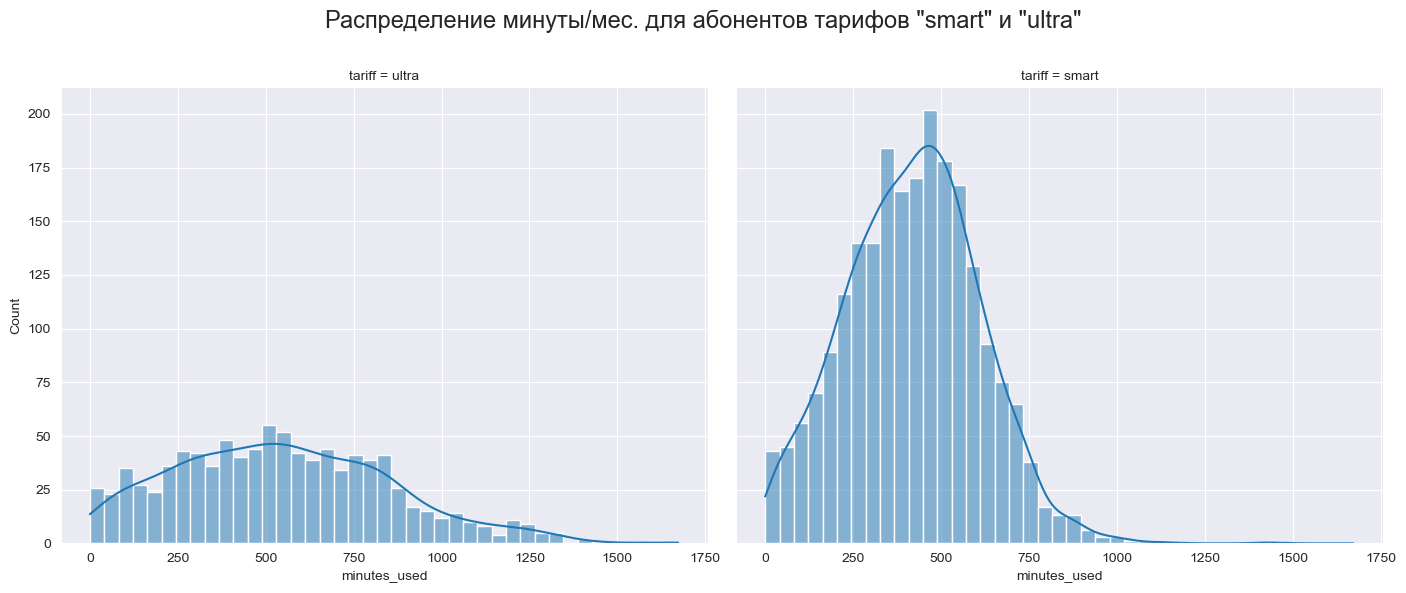

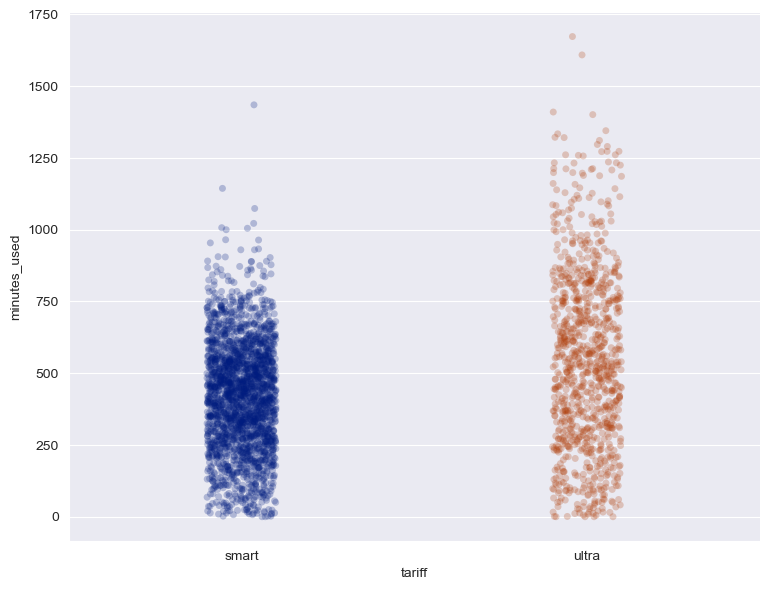

In [77]:
draw_dstr(calls_per_months, 'minutes_used', 'Распределение минуты/мес. для абонентов тарифов "smart" и "ultra"')

**Вывод:** выборочное среднее по кол-ву минут в месяц между абонентами тарифов `ultra` и `smart` отличается примерно в 1,3 раза (545, 419). Дисперсия для тарифа `ultra` в 2,6 раза больше, чем для тарифа `smart` (94203, 35844),  стандартное отклонение для тарифа `ultra` примерно в 1,6 раза больше, чем для тарифа `smart` (307, 189), это заметно по более пологому распределению для тарифа `ultra`. Обе выборки немного скошены вправо, присутствуют выбросы "справа".

### Распределение кол-ва сообщений в зависимости от тарифа
<a class=anchor id=five-two></a>

Рассчитаем показатели для кол-ва сообщений (шт.):

In [78]:
make_stat_df(messages_per_months, 'messages_qty')

,ultra,smart
выборочное среднее,61.16,38.72
дисперсия,2109.66,717.59
стандартное отклонение,45.93,26.79


Строим гистограммы распределения

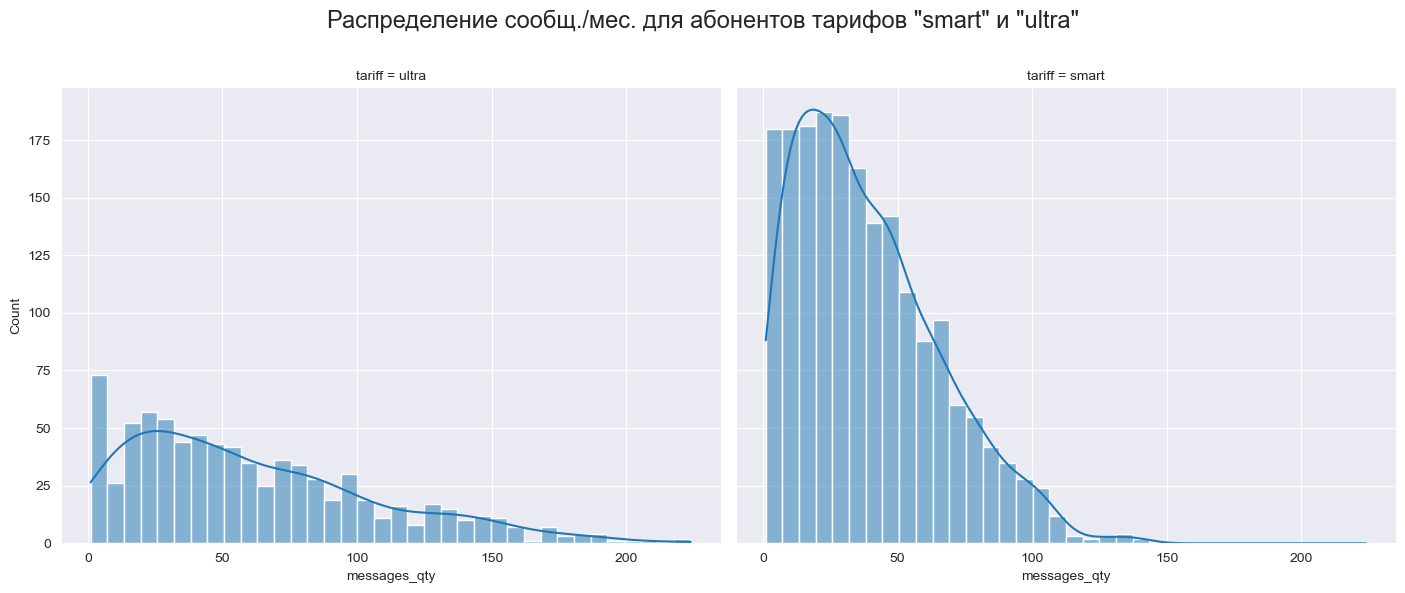

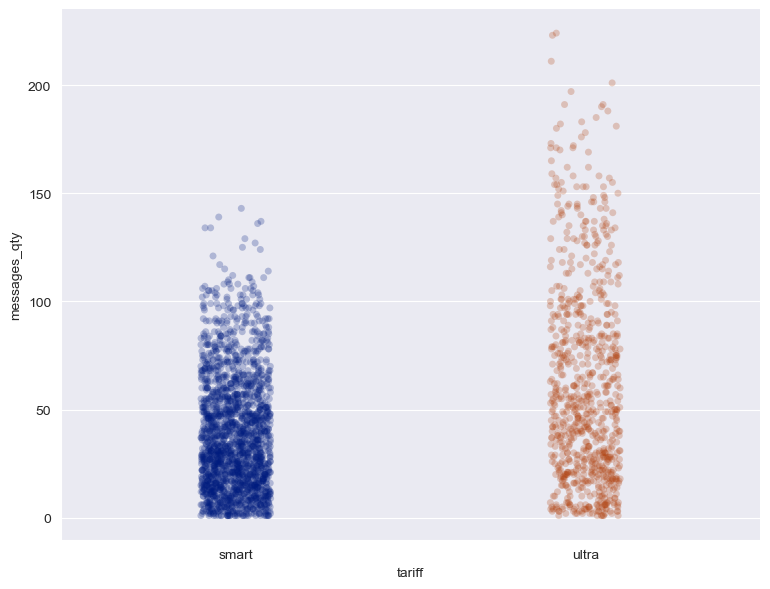

In [79]:
draw_dstr(messages_per_months, 'messages_qty', 'Распределение сообщ./мес. для абонентов тарифов "smart" и "ultra"')

**Вывод:** выборочное среднее по кол-ву сообщений в месяц между абонентами тарифов `ultra` и `smart` отличается примерно в 1,6 раза (61, 39). Дисперсия для тарифа `ultra` почти в 3 раза больше, чем для тарифа `smart` (2109, 717), стандартное отклонение для тарифа `ultra` почти в 1,7 раза больше, чем для тарифа `smart` (46, 27). Это заметно по более пологому распределению для тарифа `ultra`. Обе выборки сильно скошены вправо.

### Распределение использованного трафика (Гб) в зависимости от тарифа
<a class=anchor id=five-three></a>

Рассчитаем показатели для `использованного` абонентами трафика (Гб):

`*` использованный - фактический трафик, рассчитанный по правилам Оператора

In [80]:
make_stat_df(internet_per_months, 'gb_per_month_calc')

,ultra,smart
выборочное среднее,19.69,16.34
дисперсия,94.15,32.92
стандартное отклонение,9.70,5.74


Строим гистограммы распределения

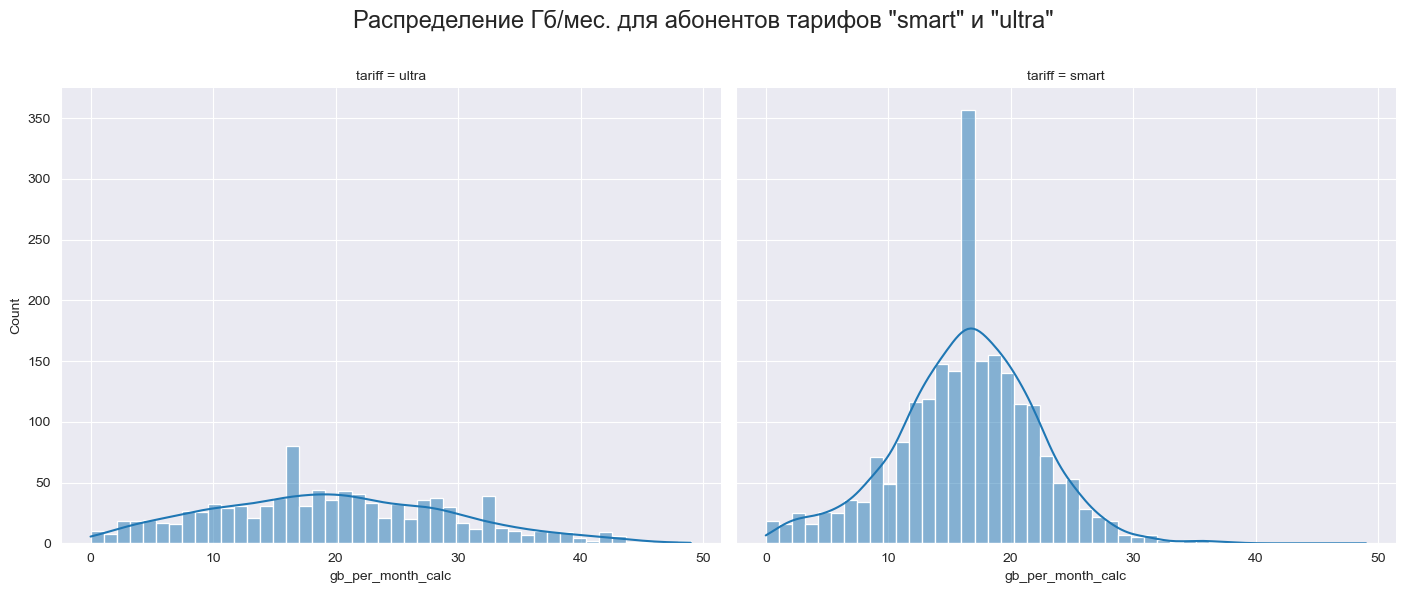

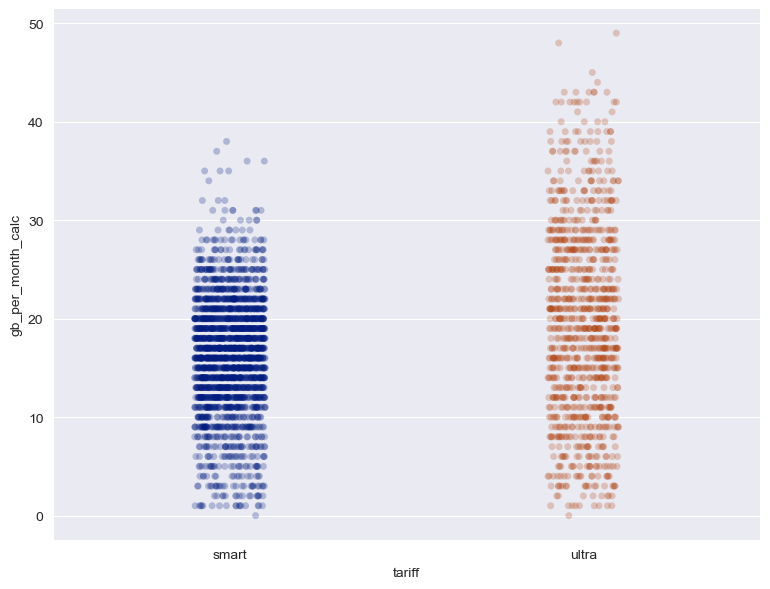

In [81]:
draw_dstr(internet_per_months, 'gb_per_month_calc', 'Распределение Гб/мес. для абонентов тарифов "smart" и "ultra"')

**Вывод:** выборочное среднее по трафику в месяц (Гб) между абонентами тарифов `ultra` и `smart` отличается примерно в 1,2 раза (20, 16). Дисперсия для тарифа `ultra` почти в 3 раза больше, чем для тарифа `smart` (94, 33), стандартное отклонение для тарифа `ultra` почти в 1,7 раза больше, чем для тарифа `smart` (9.7, 5.7). Это заметно по более пологому распределению для тарифа `ultra`. Обе выборки практически симметричны. Диаграммы разброса имеют "дискретный" (полосками) вид из-за особенностей рассчета трафика - фактическое значение округляется вверх до целых Гб.

### Описание поведения абонентов
<a class=anchor id=five-four></a>

Исходя из выборок можно зафиксировать следующие характеристики:

АБОНЕНТЫ ТАРИФА `smart`:
- среднее по минутам 419 при лимите 500
- среднее по сообщениям 39 при лимите 50
- среднее по Гб 16.34 при лимите 15

при этом:
- по минутам примерно 2/3 абонентов укладываются в лимит 500 мин, остальная 1/3 превышает. Максимальные показатели (выбросы) - до 1500 минут.
- по сообщениям примерно 1/2 абонентов укладывается в лимит 50 сообщений и 1/2 превышает. Максимальные показатели (выбросы) - примерно до 145 сообщений.
- по трафику примерно 1/2 абонентов укладывается в лимит 15 Гб и 1/2 превышает. Максимальные показатели (выбросы) - примерно до 38Гб.



АБОНЕНТЫ ТАРИФА `ultra` :
- среднее по минутам 545 при лимите 3000
- среднее по сообщениям 61 при лимите 1000
- среднее по Гб 19.69 при лимите 30


при этом:
- по минутам превышения лимита по выборке не фиксируется. Макс показатели (выбросы) - примерно до 1700 минут.
- по сообщениям превышения лимита по выборке не фиксируется. Максимальные показатели (выбросы) - примерно до 240 сообщений.
- по трафику примерно 3/4 абонентов укладывается в лимит 30 Гб и 1/4 превышает. Максимальные показатели (выбросы) - до 48..49 Гб.

## Проверка гипотез
<a class=anchor id=six></a>

### Средняя выручка абонентов тарифов «Ультра» и «Смарт»
<a class=anchor id=six-one></a>

Сформулируем нулевую и альтернативную гипотезы:
- H0 средняя выручка абонентов тарифов "Смарт" и "Ультра" **равны**
- H1 средняя выручка абонентов тарифов "Смарт" и "Ультра" **отличается**

Сформируем две одинаковых  по размеру выборки по значениям итоговой выручки абонента `rub_total`. При этом можно считать, что это две случайные выборки из соответствующих независимых генеральных совокупностей.

In [82]:
smart_select = list(user_pivot_calc[user_pivot_calc['tariff'] == 'smart']['rub_total'].reset_index(drop=True))
ultra_select = list(user_pivot_calc[user_pivot_calc['tariff'] == 'ultra']['rub_total'].reset_index(drop=True))

In [83]:
def adjust_size(lst_1, lst_2):
    '''уравнивание размеров двух списков по значению размера минимального из двух'''
    
    if len(lst_1) == len(lst_2):
        return lst_1, lst_2
    elif len(lst_1) < len(lst_2):
        lst_2 = random.sample( lst_2, len(lst_1) )
    else:
        lst_1 = random.sample( lst_1, len(lst_2) )
    return lst_1, lst_2

In [84]:
smart_select, ultra_select = adjust_size(smart_select, ultra_select)

Для применения t-теста должны выполняться 3 условия:
- генеральные совокупности должны быть независимы. Это выполняется, абоненты разных тарифов друг на друга не влияют.
- выборочное среднее распределено нормально относительно истинного среднего генеральной совокупности. Выполняется согласно ЦПТ.
- дисперсии генеральных совокупностей должны быть равны.

Последнее условие вызывает сомнения так как абоненты тарифов ведут себя по-разному и характеристики отличаются. Лучше исходить из того, что дисперсии генеральных совокупностей *не* равны.


Итак:
- Применяем метод `st.ttest_ind` для сравнения средних двух независимых совокупностей
- При применении t-теста укажем `equal_var = False`

Зададим уровень статистической значимости

In [85]:
alpha = .01

Вычисляем p-value, принимаем решение "принять / отвернуть" нулевую гипотезу.

In [86]:
results = st.ttest_ind(
    smart_select,
    ultra_select,
    equal_var = False
)

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.689340044038011e-113
Отвергаем нулевую гипотезу


Посмотрим, какие расчетные результаты можно получить по выборочным данным

In [87]:
make_stat_df(user_pivot_calc, 'rub_total')

,ultra,smart
выборочное среднее,2070.15,1289.97
дисперсия,141516.75,669785.71
стандартное отклонение,376.19,818.40


выборочные средние действительно сильно отличаются и похоже, что средняя выручка по тарифу "Ультра" отличается в бОльшую сторону.

**Вывод:** вероятность получения выборок, которые есть в нашем распоряжении, при верности гипотезы о равенстве средних генеральных совокупностей, менее 1% (а точное значение стремится к нулю). Поэтому нулевая гипотеза о равенстве средних двух совокупностей отвергнута и выбрана альтернативная гипотеза - средние значения выручки абонентов тарифов "Смарт" и "Ультра" отличаются.

### Средняя выручка абонентов из Москвы и других регионов
<a class=anchor id=six-two></a>

Сформулируем нулевую и альтернативную гипотезы:
- H0 средняя выручка абонентов из Москвы и других регионов **равны**
- H1 средняя выручка абонентов из Москвы и других регионов **отличается**

Сформируем две раных по размеру выборки по выручке абонентов из Москвы и из других регионов

In [88]:
mscw_select = list(
    user_pivot_calc
    .merge(
        users[['user_id', 'city']],
        on='user_id',
        how='left'
    )
    .query('city == "москва"')['rub_total']
)


other_select = list(
    user_pivot_calc
    .merge(
        users[['user_id', 'city']],
        on='user_id',
        how='left'
    )
    .query('city != "москва"')['rub_total']
)


mscw_select, other_select = adjust_size(mscw_select, other_select)

Совокупности считаем независимыми (абоненты не влияют друг на друга). Дисперсии совокупносей полагаем разными, так как распределения выручки в Москве и в регионах скорее всего отличаются.

- Применяем метод `st.ttest_ind` для сравнения средних двух независимых совокупностей
- При применении t-теста укажем `equal_var = False`
- alpha оставляем раным 1%

In [89]:
results = st.ttest_ind(
    mscw_select,
    other_select,
    equal_var = False
)

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.4672005591410622
Не получилось отвергнуть нулевую гипотезу


**Вывод:** отвергнуть нулевую гипотезу не получилось, поэтому принимаем гипотезу, что средняя выручка абонентов из Москвы и из других регионов не отличается.

## Вывод
<a class=anchor id=seven></a>

Основная цель исследования - ответить на вопрос "какой тариф приносит больше денег", чтоб понять какой из тарифов наиболее перспективен.

По результатам исследования видно, что абоненты разных тарифов по разному утилизируют лимиты, предоставленные оператором.
Абоненты тарифа "Смарт" при меньшей абонентской плате приносят дополнительные платежи за переиспользование лиимитов (минуты, сообщения, Гб), а абоненты тарифа "Ультра" наоборот - при бОльшей абонентской плате в основном не добирают лимиты тарифа.

Средняя выручка абонентов отличается, и, предположительно, в пользу абонентов тарифа "Ультра" (2070 руб/мес. для абонентов "Ультра" против ~ 1290 руб./ мес. для абонентов "Смарт")

При этом разницы в средней выручке между самой доходной территорией  - Москвой - и другими регионами не выявлено. Тоесть абоненты одинаково откликаются на возможности тарифов и их поведение не меняется в зависимости от территории.

По результатам видно, что тариф "Ультра" более перспективен, так как выборочное среднее по выручке у него отличается от тарифа "Смарт" и вероятно, что это отличие в бОльшую сторону.